In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.compat.v2 as tf

from keras import backend
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.utils.vis_utils import plot_model

from PIL import Image

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [2]:
class CONFIG:
    INDEXS = ["R2", "EV", "ME", "MEAN_AE", "MSE", "MEDIAN_AE", "HIT@10", "HIT@100"]
    N_SPLITS = 5

# Load Dataset

In [3]:
header = pd.read_csv("Dataset/header.csv", header=None)
header

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable


In [4]:
training_dataset = pd.read_csv("Dataset/Training/Features_Variant_5.csv",
                               header=None,
                               names=[header.iat[0, i] for i in range(0, 54)])
training_dataset.sample(n=10)

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday-Friday,Post published weekday-Saturday,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
62090,416948,0,57260,18,0.0,1304.0,88.619409,53.0,110.630725,0.0,...,0,0,0,0,0,0,1,0,0,2
145844,1959278,0,12641,18,0.0,540.0,22.968182,12.0,46.110755,0.0,...,1,0,1,0,0,0,0,0,0,0
105508,3280313,1,39324,14,0.0,1609.0,199.646817,149.0,194.176211,0.0,...,0,0,0,1,0,0,0,0,0,62
125508,246883,15,10884,24,0.0,780.0,21.007576,6.0,62.481403,0.0,...,0,0,0,0,0,1,0,0,0,0
43131,155266,1284,2454,60,0.0,16.0,1.421976,0.0,2.262170,0.0,...,0,0,0,0,1,0,0,0,0,0
65583,66311,600,442,75,0.0,6.0,0.806748,1.0,1.128038,0.0,...,0,0,0,0,0,1,0,0,0,0
44409,242526,323,701,4,0.0,122.0,4.343075,2.0,9.449348,0.0,...,0,1,1,0,0,0,0,0,0,0
167908,100625,1,1280,105,0.0,20.0,4.502841,3.0,4.398475,0.0,...,0,0,0,0,0,1,0,0,0,0
170622,19320,0,15,36,0.0,15.0,3.429668,2.0,3.826752,0.0,...,0,1,0,1,0,0,0,0,0,0
16513,3002026,0,77240,9,0.0,854.0,70.686555,35.0,102.979855,0.0,...,1,0,0,0,0,0,0,1,0,35


# Data Preprocessing

In [5]:
post_published_weekday = (training_dataset["Post published weekday-Monday"]
                          + training_dataset["Post published weekday-Tuesday"]
                          + training_dataset["Post published weekday-Wednesday"]
                          + training_dataset["Post published weekday-Thursday"]
                          + training_dataset["Post published weekday-Friday"]).astype("int")
post_published_weekend = (training_dataset["Post published weekday-Sunday"]
                          + training_dataset["Post published weekday-Saturday"]).astype("int")
training_dataset.insert(46, "Post published weekday", post_published_weekday)
training_dataset.insert(47, "Post published weekend", post_published_weekend)
training_dataset.drop(
    ["Post published weekday-Saturday",
     "Post published weekday-Sunday",
     "Post published weekday-Monday",
     "Post published weekday-Tuesday",
     "Post published weekday-Wednesday",
     "Post published weekday-Thursday",
     "Post published weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Post published weekday,Post published weekend,Base DateTime weekday-Sunday,Base DateTime weekday-Monday,Base DateTime weekday-Tuesday,Base DateTime weekday-Wednesday,Base DateTime weekday-Thursday,Base DateTime weekday-Friday,Base DateTime weekday-Saturday,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,1,0,0,0,0,0,0,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,1,0,0,0,0,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,1,0,0,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1,0,0,0,0,0,1,0,0,17


In [6]:
base_datetime_weekday = (training_dataset["Base DateTime weekday-Monday"]
                          + training_dataset["Base DateTime weekday-Tuesday"]
                          + training_dataset["Base DateTime weekday-Wednesday"]
                          + training_dataset["Base DateTime weekday-Thursday"]
                          + training_dataset["Base DateTime weekday-Friday"]).astype("int")
base_datetime_weekend = (training_dataset["Base DateTime weekday-Sunday"]
                          + training_dataset["Base DateTime weekday-Saturday"]).astype("int")
training_dataset.insert(48, "Base DateTime weekday", base_datetime_weekday)
training_dataset.insert(49, "Base DateTime weekend", base_datetime_weekend)
training_dataset.drop(
    ["Base DateTime weekday-Saturday",
     "Base DateTime weekday-Sunday",
     "Base DateTime weekday-Monday",
     "Base DateTime weekday-Tuesday",
     "Base DateTime weekday-Wednesday",
     "Base DateTime weekday-Thursday",
     "Base DateTime weekday-Friday"], axis = 1, inplace = True)
training_dataset

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend,Target Variable
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,25,166,2,0,24,1,0,1,0,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,70,132,1,0,24,1,0,0,1,0
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,26,133,2,0,24,1,0,0,1,0
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,67,131,1,0,24,1,0,1,0,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,65,142,5,0,24,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,16,77,2123,0,24,1,0,1,0,203
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,4,130,474,0,24,1,0,1,0,42
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,12,12,1511,0,24,1,0,1,0,51
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,31,149,1099,0,24,1,0,1,0,17


In [7]:
features = training_dataset.iloc[:, :43]
features

,Page Popularity/likes,Page Checkinsâ€™s,Page talking about,Page Category,Derived5,Derived6,Derived7,Derived8,Derived9,Derived10,...,CC5,Base time,Post length,Post Share Count,Post Promotion Status,H Local,Post published weekday,Post published weekend,Base DateTime weekday,Base DateTime weekend
0,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,25,166,2,0,24,1,0,1,0
1,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,70,132,1,0,24,1,0,0,1
2,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,26,133,2,0,24,1,0,0,1
3,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,67,131,1,0,24,1,0,1,0
4,634995,0,463,1,0.0,1280.0,13.158779,1.0,94.993640,0.0,...,0,65,142,5,0,24,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199025,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,1940,16,77,2123,0,24,1,0,1,0
199026,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,155,4,130,474,0,24,1,0,1,0
199027,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,207,12,12,1511,0,24,1,0,1,0
199028,7170111,70,497000,9,0.0,2164.0,466.975207,244.0,497.966169,0.0,...,-459,31,149,1099,0,24,1,0,1,0


In [8]:
labels = training_dataset.iloc[:, -1:]
labels

,Target Variable
0,0
1,0
2,0
3,0
4,0
...,...
199025,203
199026,42
199027,51
199028,17


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3, random_state=42)

# Fully Connected Neural Network

## Normalization

In [10]:
def normalize(X_train, X_test, y_train, y_test):
    x_scaler = StandardScaler()
    x_scaler.fit(X_train)
    X_train_norm = x_scaler.transform(X_train)
    X_test_norm = x_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    y_train_norm = y_scaler.transform(y_train)
    y_test_norm = y_scaler.transform(y_test)
    return X_train_norm, X_test_norm, y_train_norm, y_test_norm

## Data Preprocessing

### Random Forest

In [11]:
def feature_selection(X_train_norm_df, y_train_norm_df):
    rf_model = RandomForestRegressor(
        max_depth=12,
        min_samples_split=0.0001,
        n_estimators=30,
        random_state=42,
    )
    rf_model.fit(X_train_norm_df, y_train_norm_df.values.ravel())
    
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [X_train_norm_df.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    sfm = SelectFromModel(rf_model, threshold=0.02, prefit=True)
    selected_feature_ids = sfm.get_support()
    selected_features = X_train_norm_df.columns[selected_feature_ids]
    return selected_features

### PCA

In [12]:
def pca(X_train_norm_df):
    pca = PCA()
    pca.fit(X_train_norm_df)
    X_train_norm_df_reduction = pca.transform(X_train_norm_df)
    
    plt.plot([i for i in range(X_train_norm_df.shape[1])], 
         [np.sum(pca.explained_variance_ratio_[:i]) for i in range(X_train_norm_df.shape[1])])
    plt.show()

## Loss Function

https://github.com/keras-team/keras/blob/master/keras/losses.py

In [13]:
# loss = |y_true * (y_pred - y_true)|
# loss = mean(abs(y_true * (y_pred - y_true)), axis=-1)
def y_true_mean_absolute_error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return backend.mean(tf.abs(y_true * (y_pred - y_true)), axis=-1)

## Model Initialization

In [14]:
def create_model(input_shape):
    # Sequential
    model = Sequential()
    model.add(Dense(units=30,
                    activation='relu',
                    input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(units=15,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='y_true_mean_absolute_error', optimizer='adam')
    print(model.summary())
    return model

## Model Training

In [15]:
def train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm):
    model = load_model('model_fcnn.h5', custom_objects={'loss': y_true_mean_absolute_error})
    train = model.fit(X_train_norm,
                      y_train_norm,
                      epochs=100,
                      batch_size=1024,
                      verbose=1,
                      validation_data=(X_test_norm, y_test_norm))
    model.save('model_fcnn.h5')
    predict = model.predict(X_test_norm)
    plt.plot(train.history['loss'])  
    plt.plot(train.history['val_loss'])  
    plt.title('Model loss')  
    plt.ylabel('Loss')  
    plt.xlabel('Epoch')  
    plt.legend(['Train', 'Test'], loc='upper left')  
    plt.show()
    plt.figure(figsize=(10, 15))
    plot_model(model, to_file='model_fcnn.png', show_shapes=True)
    img = Image.open('model_fcnn.png', 'r')
    plt.imshow(np.asarray(img))
    plt.show()
    return predict

In [16]:
def plot_test_predict(y_train, y_test_norm, predict, axes=None, k=None):
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    test_predict = pd.concat(
        [pd.DataFrame(y_scaler.inverse_transform(y_test_norm)),
         pd.DataFrame(y_scaler.inverse_transform(predict.reshape(-1, 1)))
    ], axis=1)
    headers =  ["Test", "Predict"]
    test_predict.columns = headers
    if axes is not None and k is not None:
        sns.lineplot(data=test_predict, ax=axes[k]).set_title("Test Predict Line Plot k = " + str(k))
    else:
        sns.lineplot(data=test_predict).set_title("Test Predict Line Plot")
    plt.show()
    if axes is not None and k is not None:
        sns.scatterplot(data=test_predict, x="Test", y="Predict", ax=axes[k]).set_title("Test Predict Sctter Plot k = " + str(k))
    else:
        sns.scatterplot(data=test_predict, x="Test", y="Predict").set_title("Test Predict Sctter Plot")
    plt.show()
    x_residual = y_scaler.inverse_transform(predict.reshape(-1, 1))
    y_residual = y_scaler.inverse_transform(y_test_norm) * (y_scaler.inverse_transform(predict.reshape(-1, 1)) - y_scaler.inverse_transform(y_test_norm))
    sns.residplot(x=x_residual, lowess=True, y=y_residual).set_title("Residuals")
    plt.show()
    x_residual = y_scaler.inverse_transform(predict.reshape(-1, 1))
    y_residual = y_scaler.inverse_transform(y_test_norm)
    sns.residplot(x=x_residual, lowess=True, y=y_residual).set_title("Residuals")
    plt.show()

## Model Evaluation

In [17]:
def evaluate(model, y_train, X_test_norm, y_test_norm, predict):
    y_scaler = StandardScaler()
    y_scaler.fit(y_train)
    
    # R-Squared
    r2 = r2_score(y_scaler.inverse_transform(y_test_norm),
                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Explained Variance Score
    ev = explained_variance_score(y_scaler.inverse_transform(y_test_norm),
                                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Max Error
    me = max_error(y_scaler.inverse_transform(y_test_norm), 
                   y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Mean Absolute Error
    mean_ae = mean_absolute_error(y_scaler.inverse_transform(y_test_norm),
                                  y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Mean Squared Error
    mse = mean_squared_error(y_scaler.inverse_transform(y_test_norm),
                             y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Median Absolute Error
    median_ae = median_absolute_error(y_scaler.inverse_transform(y_test_norm), 
                                      y_scaler.inverse_transform(predict.reshape(-1, 1)))
    
    # Hit@10
    hit = np.abs(
        y_scaler.inverse_transform(y_test_norm).flatten() - 
        y_scaler.inverse_transform(predict.reshape(-1, 1)).flatten()
    ) < 10
    hit_10 = np.sum(hit) / hit.shape[0]
    
    # Hit@100
    y_test_np = y_scaler.inverse_transform(y_test_norm).flatten()
    ordered_y_test = np.argsort(y_test_np)
    max_y_test = ordered_y_test[-100:]
    ordered_predict = np.argsort(y_scaler.inverse_transform(predict.reshape(-1, 1)).flatten())
    max_predict = ordered_predict[-100:]
    acc = 0
    for pred in max_predict:
        if pred in max_y_test:
            acc += 1
    hit_100 = acc / 100
    
    return r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100

## Final Model

In [18]:
def train_final_model():
    # Normalization
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = normalize(X_train, X_test, y_train, y_test)
    
    # Data Preprocessing
    X_train_norm_df = pd.DataFrame(data=X_train_norm)
    X_test_norm_df = pd.DataFrame(data=X_test_norm)
    y_train_norm_df = pd.DataFrame(data=y_train_norm)
    y_test_norm_df = pd.DataFrame(data=y_test_norm)

    selected_features = feature_selection(X_train_norm_df, y_train_norm_df)
    
    X_train_norm_df = X_train_norm_df[selected_features]
    X_test_norm_df = X_test_norm_df[selected_features]
    
    pca(X_train_norm_df)
    
    X_train_norm = X_train_norm_df.to_numpy()
    X_test_norm = X_test_norm_df.to_numpy()
    y_train_norm = y_train_norm_df.to_numpy()
    y_test_norm = y_test_norm_df.to_numpy()

    # Model Initialization
    model = create_model(X_train_norm_df.shape[1])

    # Model Training
    predict = train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
    plot_test_predict(y_train, y_test_norm, predict)

    # Model Evaluation
    r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100 = evaluate(model, y_train, X_test_norm, y_test_norm, predict)

    results = pd.DataFrame({
        "Index": CONFIG.INDEXS, 
        "Mean": [r2, ev, me, mean_ae, mse, median_ae, hit_10, hit_100]
    })
    print(results)

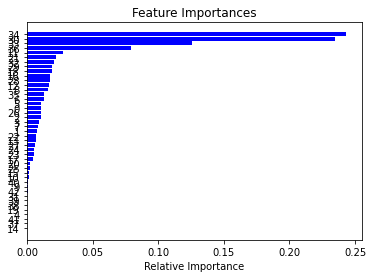

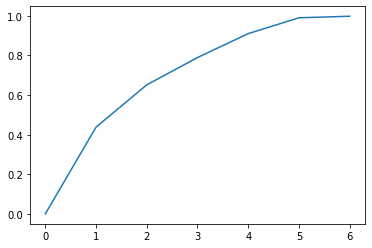

2021-11-09 20:00:38.871264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                240       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100


2021-11-09 20:00:39.133800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


137/137 [==============================] - 1s 8ms/step - loss: 0.2064 - val_loss: 0.2918
Epoch 2/100
137/137 [==============================] - 1s 7ms/step - loss: 0.2080 - val_loss: 0.2858
Epoch 3/100
137/137 [==============================] - 1s 10ms/step - loss: 0.2129 - val_loss: 0.2891
Epoch 4/100
137/137 [==============================] - 1s 7ms/step - loss: 0.2149 - val_loss: 0.2845
Epoch 5/100
137/137 [==============================] - 1s 6ms/step - loss: 0.2176 - val_loss: 0.2896
Epoch 6/100
137/137 [==============================] - 1s 7ms/step - loss: 0.2268 - val_loss: 0.2654
Epoch 7/100
137/137 [==============================] - 1s 6ms/step - loss: 0.2199 - val_loss: 0.2628
Epoch 8/100
137/137 [==============================] - 1s 6ms/step - loss: 0.2201 - val_loss: 0.2709
Epoch 9/100
137/137 [==============================] - 1s 6ms/step - loss: 0.2211 - val_loss: 0.2619
Epoch 10/100
137/137 [==============================] - 1s 6ms/step - loss: 0.2143 - val_loss: 0.2715


137/137 [==============================] - 1s 8ms/step - loss: 0.2073 - val_loss: 0.2847
Epoch 82/100
137/137 [==============================] - 1s 8ms/step - loss: 0.1968 - val_loss: 0.2923
Epoch 83/100
137/137 [==============================] - 1s 7ms/step - loss: 0.2208 - val_loss: 0.2796
Epoch 84/100
137/137 [==============================] - 1s 8ms/step - loss: 0.2099 - val_loss: 0.2734
Epoch 85/100
137/137 [==============================] - 1s 9ms/step - loss: 0.2273 - val_loss: 0.2769
Epoch 86/100
137/137 [==============================] - 1s 11ms/step - loss: 0.2167 - val_loss: 0.2848
Epoch 87/100
137/137 [==============================] - 1s 8ms/step - loss: 0.2192 - val_loss: 0.2761
Epoch 88/100
137/137 [==============================] - 1s 8ms/step - loss: 0.2076 - val_loss: 0.2868
Epoch 89/100
137/137 [==============================] - 1s 9ms/step - loss: 0.2192 - val_loss: 0.2729
Epoch 90/100
137/137 [==============================] - 1s 8ms/step - loss: 0.2148 - val_loss:

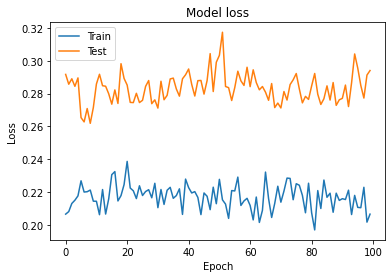

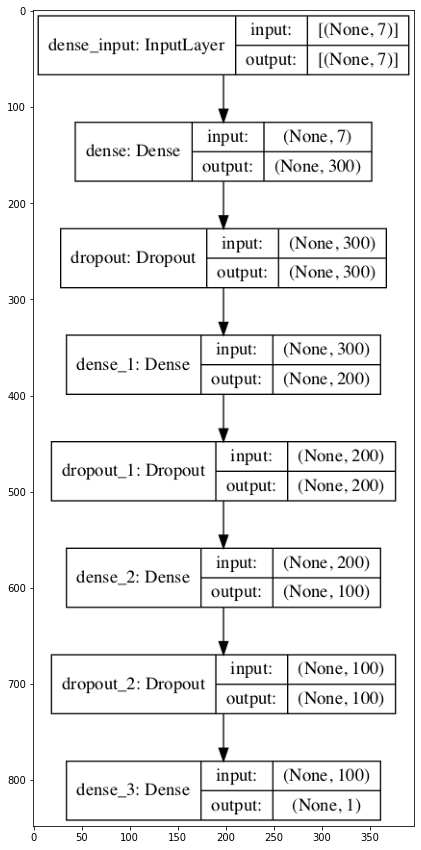

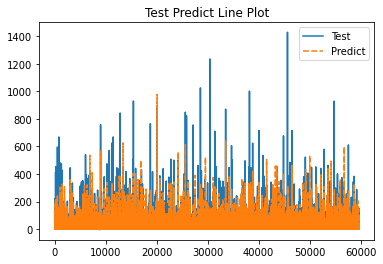

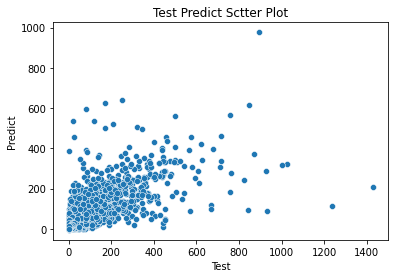

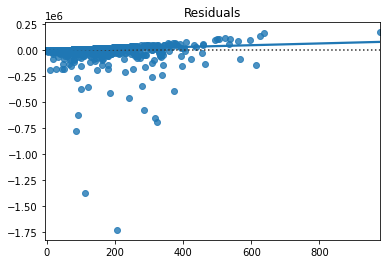

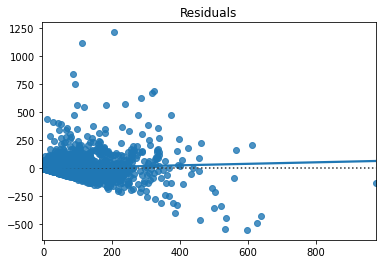

       Index         Mean
0         R2     0.644371
1         EV     0.645198
2         ME  1222.573807
3    MEAN_AE     3.727196
4        MSE   364.918619
5  MEDIAN_AE     0.506317
6     HIT@10     0.934131
7    HIT@100     0.550000


In [19]:
train_final_model()